#  Applications of Deep Neural Networks


# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab


# Part 4.3: Keras Regression for Deep Neural Networks with RMSE

We evaluate regression results differently than classification.  Consider the following code that trains a neural network for regression on the data set **jh-simple-dataset.csv**.  We begin by preparing the data set.

In [2]:
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Generate dummies for product
df = pd.concat([df,pd.get_dummies(df['product'],prefix="product")],axis=1)
df.drop('product', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('age').drop('id')
x = df[x_columns].values
y = df['age'].values

# Create train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

Next, we create a neural network to fit the data we just loaded.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Build the neural network
model = Sequential()
model.add(Dense(25, input_dim=x.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(1)) # Output
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto', 
                        restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2,epochs=1000)


Epoch 1/1000
47/47 - 1s - loss: 2031.4127 - val_loss: 1841.1775 - 918ms/epoch - 20ms/step
Epoch 2/1000
47/47 - 0s - loss: 1572.5465 - val_loss: 1150.3815 - 114ms/epoch - 2ms/step
Epoch 3/1000
47/47 - 0s - loss: 744.4590 - val_loss: 385.9300 - 118ms/epoch - 3ms/step
Epoch 4/1000
47/47 - 0s - loss: 276.0046 - val_loss: 233.2362 - 115ms/epoch - 2ms/step
Epoch 5/1000
47/47 - 0s - loss: 222.4169 - val_loss: 204.1678 - 154ms/epoch - 3ms/step
Epoch 6/1000
47/47 - 0s - loss: 193.3385 - val_loss: 177.7318 - 151ms/epoch - 3ms/step
Epoch 7/1000
47/47 - 0s - loss: 166.5165 - val_loss: 152.6439 - 113ms/epoch - 2ms/step
Epoch 8/1000
47/47 - 0s - loss: 142.2260 - val_loss: 130.3747 - 123ms/epoch - 3ms/step
Epoch 9/1000
47/47 - 0s - loss: 119.9150 - val_loss: 110.6989 - 111ms/epoch - 2ms/step
Epoch 10/1000
47/47 - 0s - loss: 100.8840 - val_loss: 94.5702 - 110ms/epoch - 2ms/step
Epoch 11/1000
47/47 - 0s - loss: 85.1441 - val_loss: 80.1229 - 111ms/epoch - 2ms/step
Epoch 12/1000
47/47 - 0s - loss: 71.739

## Mean Square Error

The mean square error (MSE) is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$).  MSE values are not of a particular unit. If an MSE value has decreased for a model, that is good. However, beyond this, there is not much more you can determine. We seek to achieve low MSE values. The following equation demonstrates how to calculate MSE.

$$ \mbox{MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $$

The following code calculates the MSE on the predictions from the neural network.

In [4]:
from sklearn import metrics

# Predict
pred = model.predict(x_test)

# Measure MSE error.  
score = metrics.mean_squared_error(pred,y_test)
print("Final score (MSE): {}".format(score))

16/16 [==============================] - 0s 6ms/step
Final score (MSE): 0.6733803437632232


## Root Mean Square Error

The root mean square (RMSE) is essentially the square root of the MSE. Because of this, the RMSE error is in the same units as the training data outcome. We desire Low RMSE values. The following equation calculates RMSE.

$$ \mbox{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2} $$

In [5]:
import numpy as np

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 0.8205975528620733


## Lift Chart

We often visualize the results of regression with a lift chart. To generate a lift chart, perform the following activities:

* Sort the data by expected output and plot these values.
* For every point on the x-axis, plot that same data point's predicted value in another color.
* The x-axis is just 0 to 100% of the dataset. The expected always starts low and ends high.
* The y-axis is ranged according to the values predicted.

You can interpret the lift chart as follows:

* The expected and predict lines should be close. Notice where one is above the other.
* The below chart is the most accurate for lower ages.

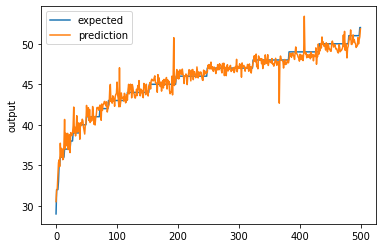

In [6]:

# Regression chart.
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Plot the chart
chart_regression(pred.flatten(),y_test)